# Impact of Brexit on UK's GDP

We'll work on estimating the causal impact of Brexit on UK's GDP. We'll build a synthetic control (ie. UK's GDP had Brexit not happened) using GDP data from other countries, first using Bayesian inference and then following a Frequentist approach.

The approach is similar to the one described in [this policy paper](https://www.cer.eu/publications/archive/policy-brief/2022/cost-brexit-so-far) (which however did not use Bayesian inference) and based on one of CausalPy's examples and datasets.

In [90]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import causalpy as cp
from causalimpact import CausalImpact

from sklearn.linear_model import LinearRegression, Ridge

import warnings
warnings.filterwarnings('ignore')

In [2]:
%config InlineBackend.figure_format = 'retina'
seed = 42

## Load data

In [5]:
# The brexit dataset contains GDP data for each quarter and country measured in units of billion USD from July 2008 to Jan 2022
df = cp.load_data("brexit")
df.head()

,Time,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Iceland,...,Luxemburg,Netherlands,New_Zealand,Norway,Portugal,Spain,Sweden,Switzerland,UK,US
0,2008-07-01,3.82370,0.835645,0.97149,17.53314,4.67639,0.55785,5.21976,7.07351,5.44478,...,0.121523,1.706577,0.47764,7.82785,0.484388,2.69860,10.86125,1.543388,4.79983,157.09562
1,2008-10-01,3.80552,0.816908,0.95042,17.32984,4.56596,0.54588,5.14178,6.96078,5.74929,...,0.117046,1.695315,0.47741,7.85237,0.478131,2.86664,10.47702,1.499977,4.70358,153.66607
2,2009-01-01,3.84048,0.802836,0.94117,16.93824,4.50096,0.51052,5.05450,6.63471,5.18157,...,0.114836,1.634391,0.47336,7.78753,0.466098,2.58309,10.32220,1.476532,4.61881,151.87475
3,2009-04-01,3.86954,0.796545,0.94162,16.75340,4.41372,0.50829,5.05375,6.64530,5.16171,...,0.116259,1.634432,0.47916,7.71903,0.466515,2.72044,10.32867,1.485509,4.60431,151.61772
4,2009-07-01,3.88115,0.799937,0.95352,16.82878,4.42898,0.51299,5.06237,6.68237,5.24132,...,0.118747,1.640982,0.48188,7.72400,0.470631,2.60550,10.32328,1.502506,4.60722,152.16647


In [8]:
# Adjust & filter the dataset
    # Note: a few countries were manually excluded from the original example because of low corr with UK. 
    # We'll run the analysis with all countries instead and explore the results accordingly.
df['Time'] = pd.to_datetime(df['Time'])
df.query('Time >= "2009-01-01"', inplace=True)
df.set_index('Time', inplace=True)

In [30]:
# Specify date of the Brexit vote announcement
treatment_time = pd.to_datetime("2016-06-24")

In [28]:
# Set useful countries list
target_country = "UK"
all_countries = list(df.columns)
other_countries = [country for country in all_countries if country != target_country]

## Data exploration

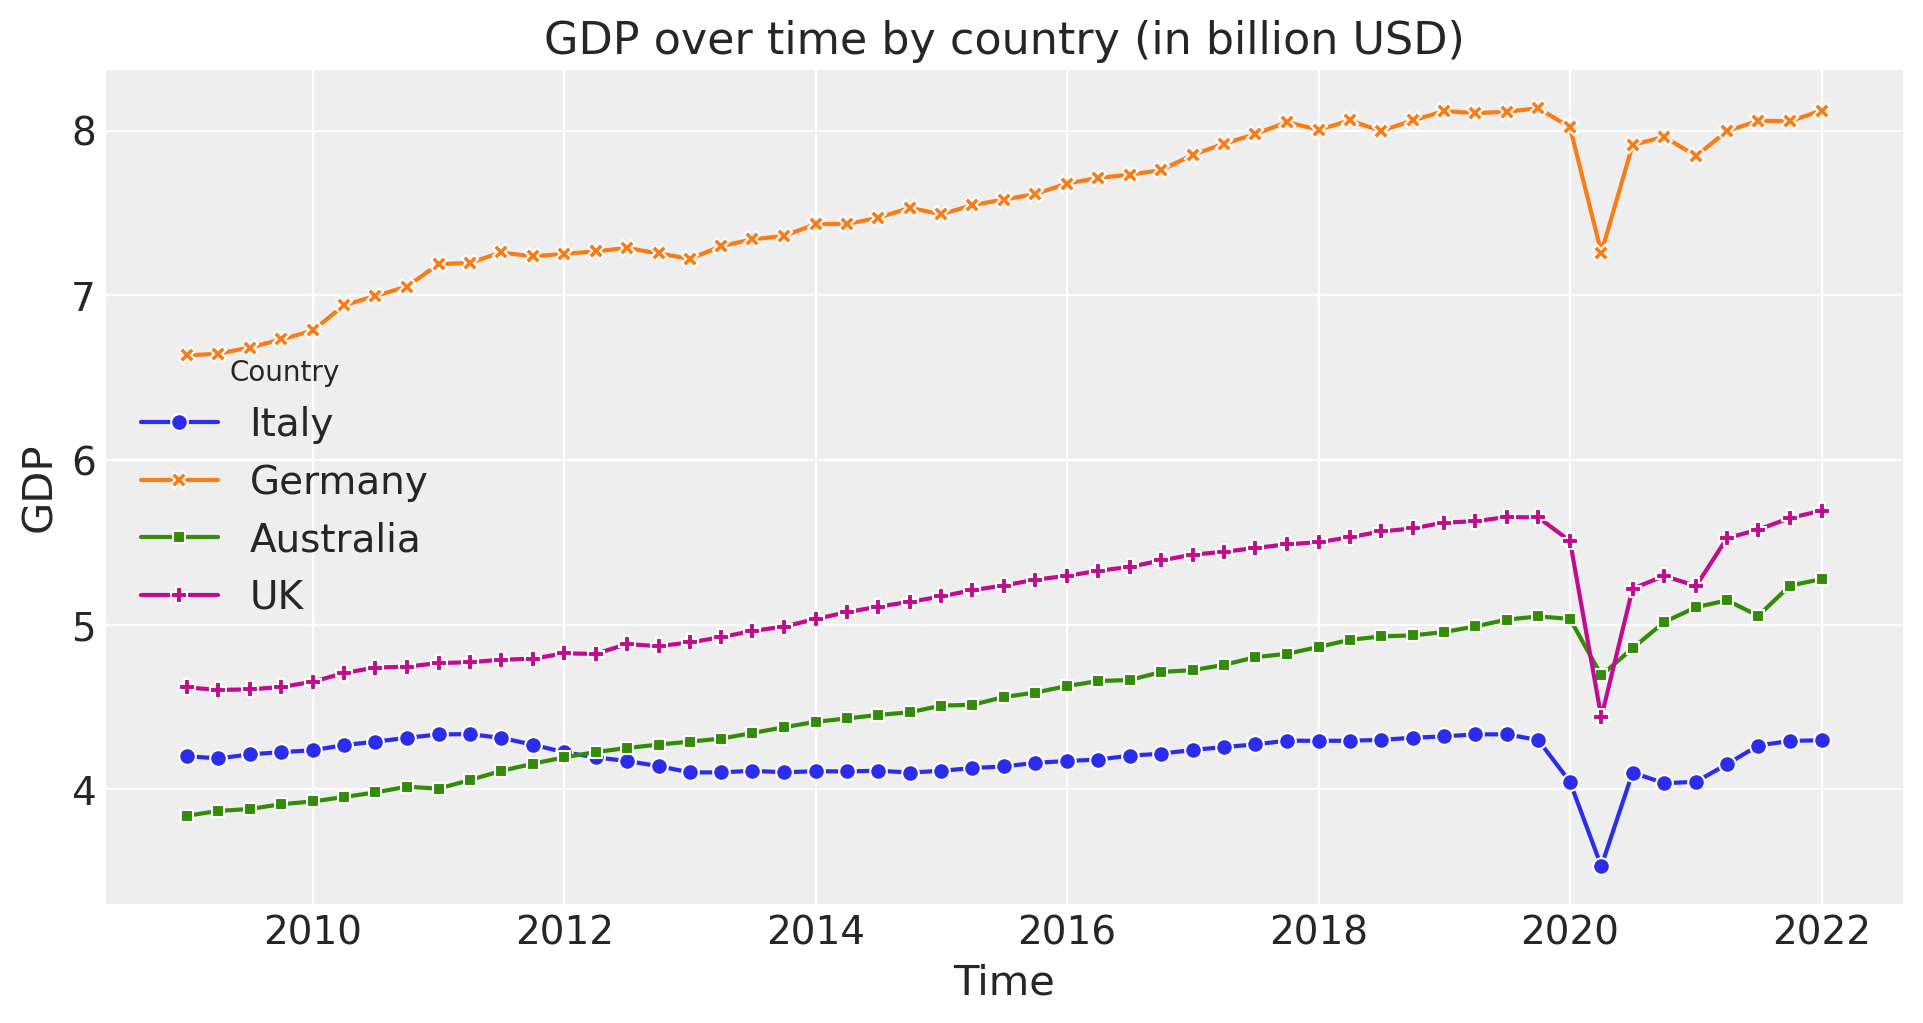

In [21]:
# Reshaping the dataset from wide to long and plot athe absolute GDP value of a few countries
df_long = df.reset_index().melt(id_vars='Time', value_vars=['Italy', 'Germany', 'Australia', 'UK'], 
                                         var_name='Country', value_name='GDP')

plt.figure(figsize=(9.5, 5))
sns.lineplot(data=df_long, x='Time', y='GDP', hue='Country', style='Country', markers=True, dashes=False)

plt.title('GDP over time by country (in billion USD)')

plt.show()

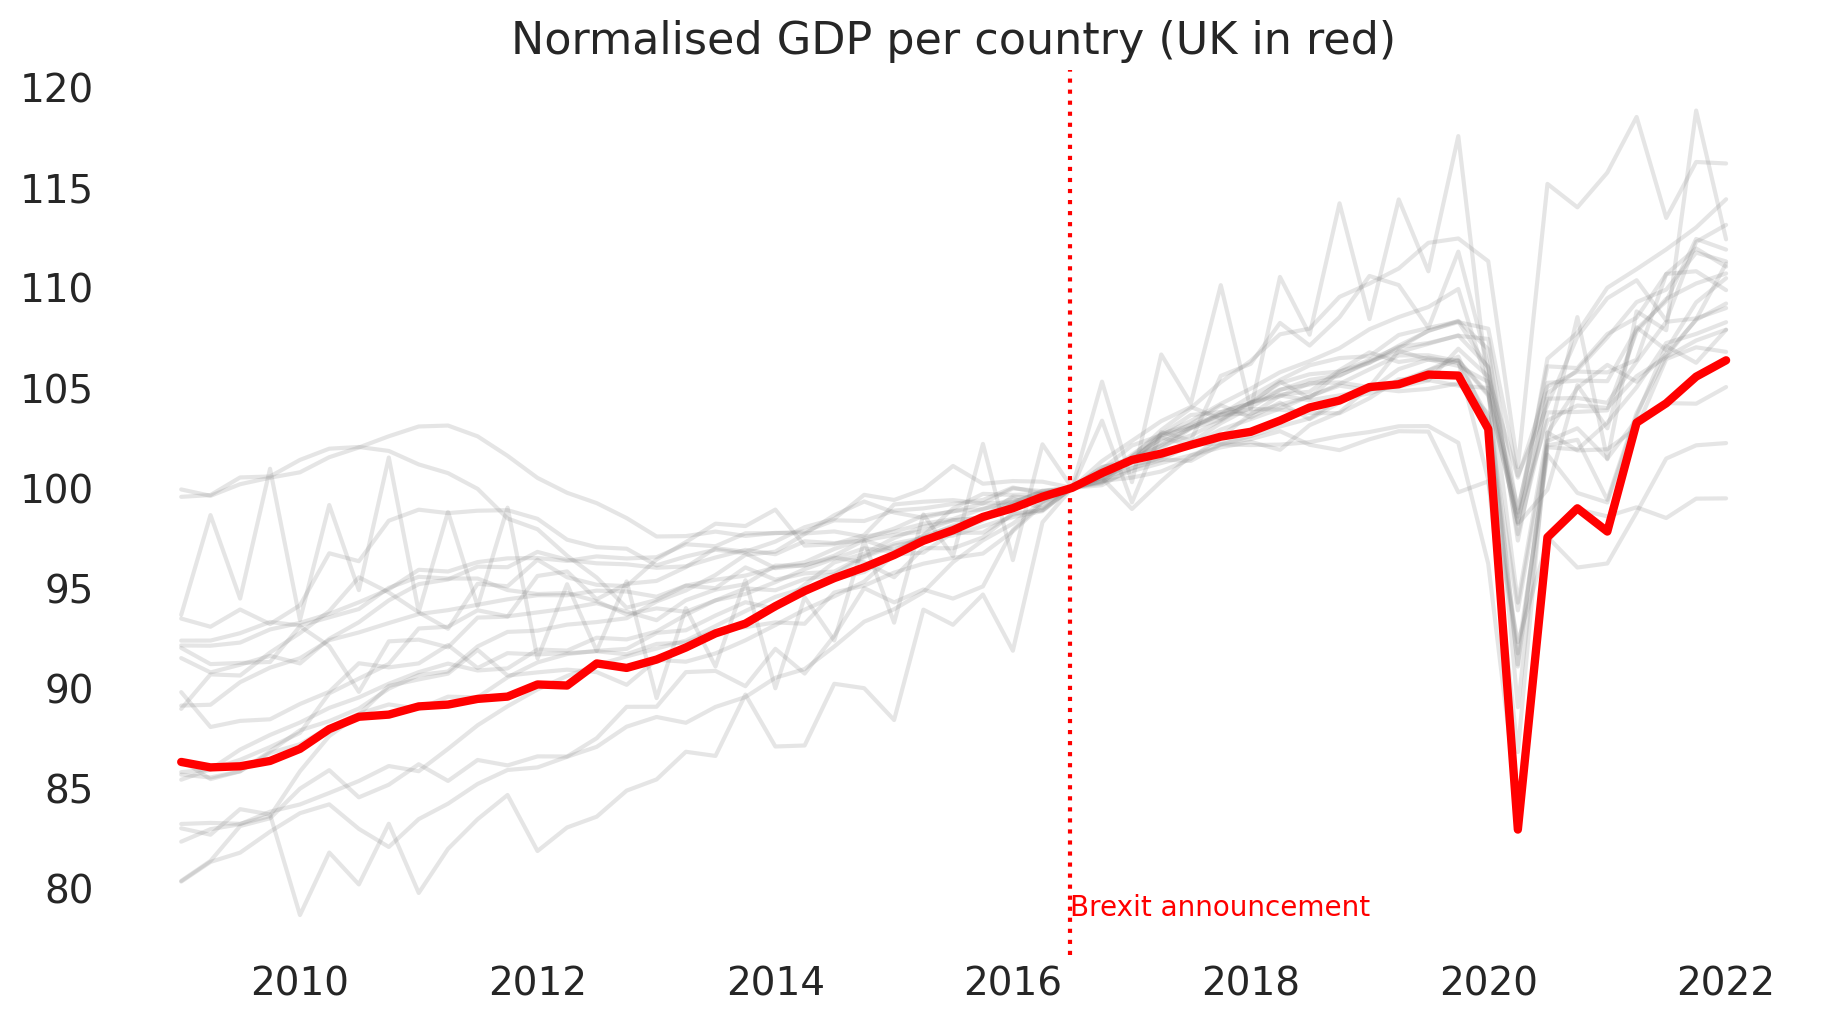

In [42]:
# Normalised the timeseries based on the value at the intervention point (Q3 2016)
gdp_at_intervention = df.loc[pd.to_datetime("2016-07-01"), :]
df_normalised = (df / gdp_at_intervention) * 100.0

# Plot
fig, ax = plt.subplots(figsize=(9, 5))
for col in other_countries:
    ax.plot(df_normalised.index, df_normalised[col], color="grey", alpha=0.2)

ax.plot(df_normalised.index, df_normalised[target_country], color="red", lw=3)
# ax = df_normalised.plot(legend=False)

ax.set(title=f"Normalised GDP per country ({target_country} in red)")
ax.axvline(x=treatment_time, color="r", ls=":")
ax.text(treatment_time, ax.get_ylim()[1]*0.66, 'Brexit announcement', horizontalalignment='left', verticalalignment='top', color='r')
ax.set_facecolor('white')

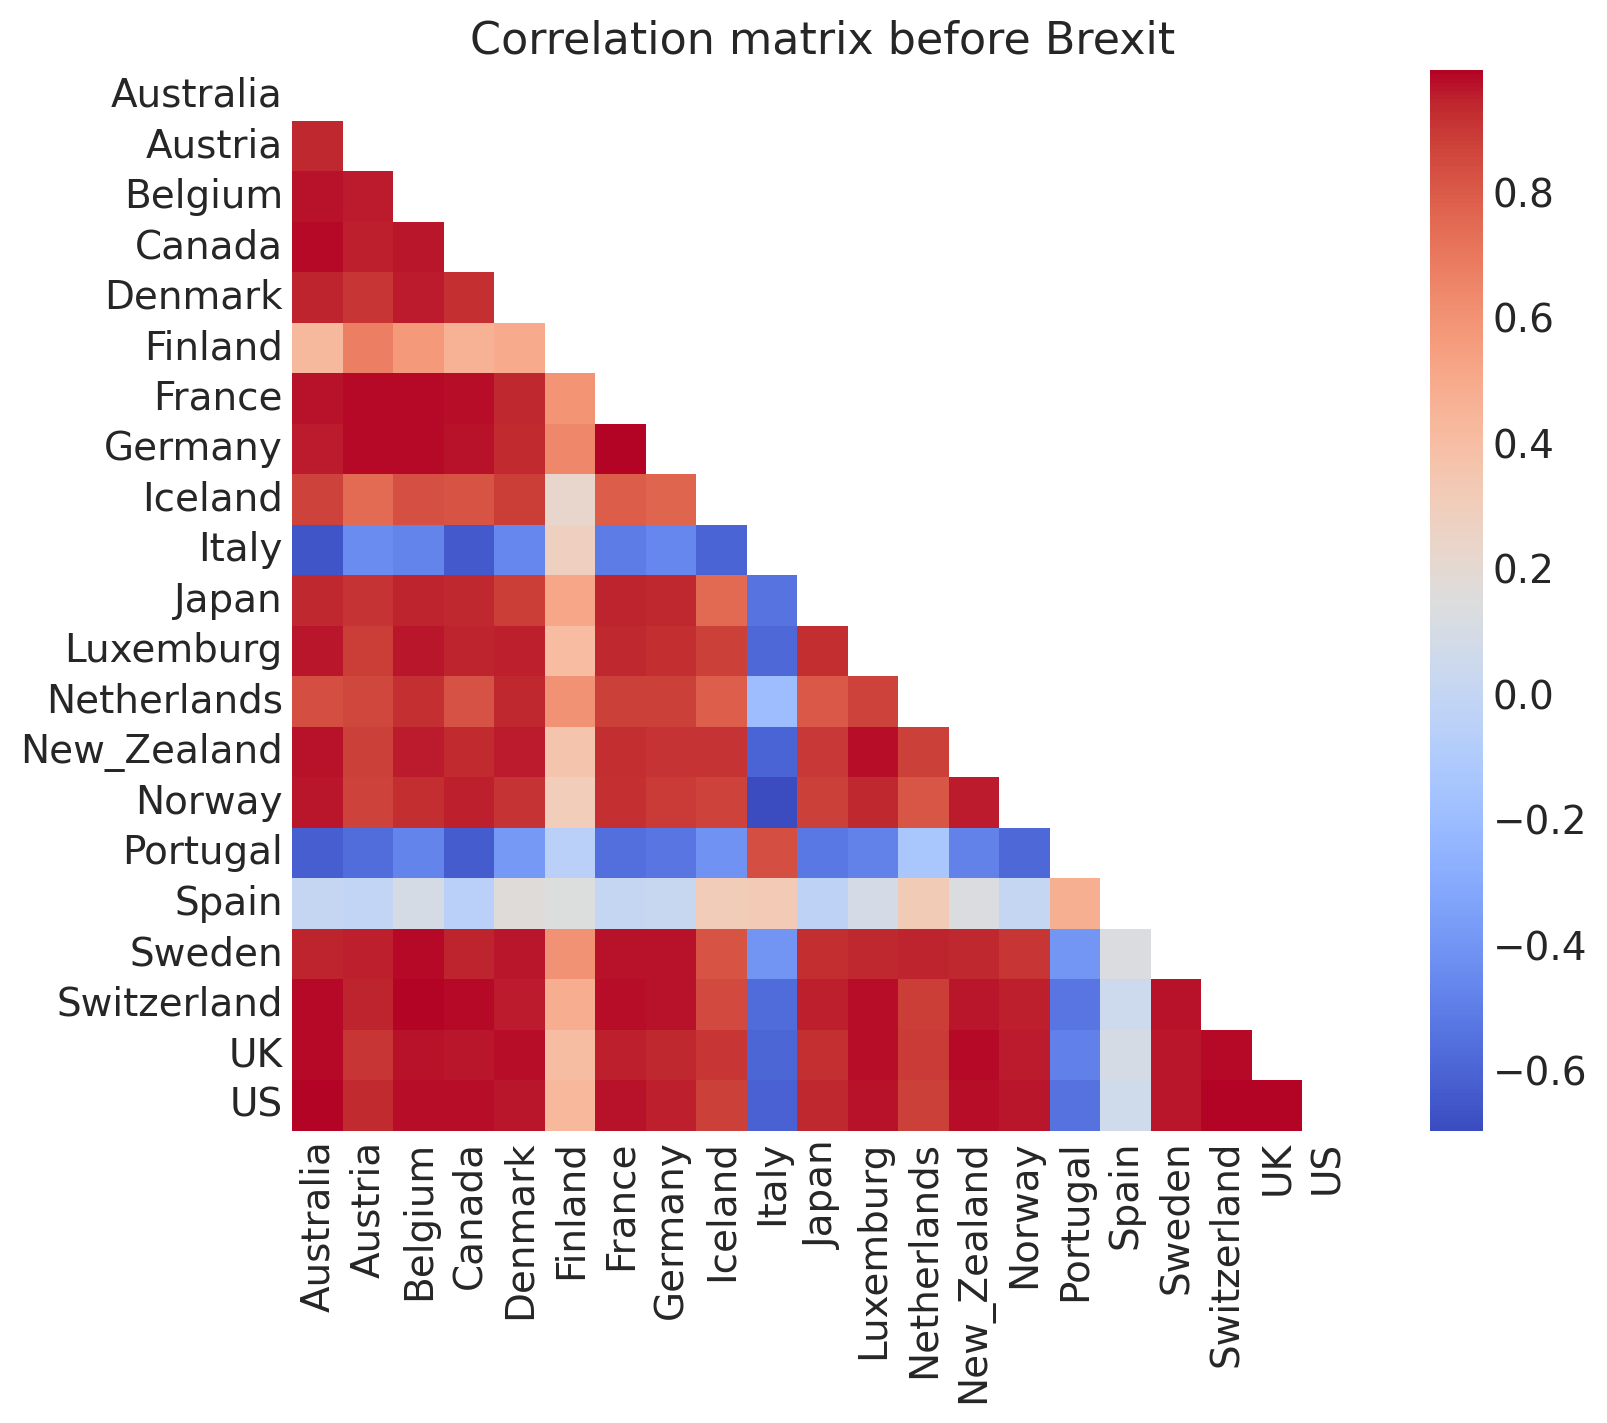

In [46]:
# Plot correlation between countries before Brexit

pre_intervention_data = df.loc[df.index < treatment_time, :]
correlation_matrix = pre_intervention_data.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(9, 7))
ax = sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', cbar=True, square=True)
plt.title("Correlation matrix before Brexit")
ax.set_facecolor('white')
plt.show()

Some countries have low correlation with our target (UK) before the intervention. As such, we expect them to contribute very little (or not at all) in the model for the synthetic control, which I explore next.

## Causal impact analysis (Bayesian approach)

In [48]:
# Define the model formula
formula = target_country + " ~ " + "0 + " + " + ".join(other_countries)
print(formula)

UK ~ 0 + Australia + Austria + Belgium + Canada + Denmark + Finland + France + Germany + Iceland + Italy + Japan + Luxemburg + Netherlands + New_Zealand + Norway + Portugal + Spain + Sweden + Switzerland + US


Next I'll build a synthetic control using one of PyMC's Bayesian models (the Weightes Sum Fitter).

This model uses a linear regression framework where:
- the coefficients (beta) are drawn from a Dirichlet distribution, implying they are positive and sum to one
- the variability around the regression line is modeled using a normal distribution with a mean determined by the linear predictor (mu = X * beta) and a variance determined by a Half-Normal distribution on sigma.

Running the model below will estimate the posterior distribution of these parameters and quantify the uncertainty in these estimates.

In [49]:
# Build a synthetic control using the Weighted Sum Fitter model
sample_kwargs = {"tune": 4000, "target_accept": 0.99, "random_seed": seed}

result = cp.pymc_experiments.SyntheticControl(
    df,
    treatment_time,
    formula=formula,
    model=cp.pymc_models.WeightedSumFitter(sample_kwargs=sample_kwargs),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]
/Users/francescoamato/miniconda3/envs/causal-inf/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



/Users/francescoamato/miniconda3/envs/causal-inf/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 280 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `t

We can then assess the convergence of the MCMC simulations in the fitting process via the Rhat statistic (Gelman-Rubin diagnostic), which compares the variance between chains to the variance within each chain. When multiple chains are run from different starting points, a well-mixed and converged set of chains should have similar variance within each chain and across the chains, indicating that they are all sampling from the same posterior distribution.

Guidelines for itnterpretation:
- Rhat = 1: This is the ideal scenario, indicating that the within-chain and between-chain variances are equal, suggesting that the chains have converged to the target distribution, and further sampling would likely yield similar results.
- Rhat > 1: Values greater than 1 indicate potential issues with convergence. 
- Rhat < 1: While theoretically possible, Rhat values less than 1 are uncommon and could indicate improper calculation or other anomalies.

A common rule of thumb is that Rhat values should be close to 1, typically below 1.1 or 1.05, to consider the chains well-mixed and converged.

In [50]:
# Explore r_hat statistics to evaluate convergence
az.summary(result.idata, var_names=["~mu"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[Australia],0.118,0.089,0.004,0.281,0.038,0.028,6.0,36.0,1.85
beta[Austria],0.035,0.046,0.000,0.126,0.012,0.009,9.0,57.0,1.37
beta[Belgium],0.074,0.053,0.001,0.171,0.013,0.009,13.0,32.0,1.25
beta[Canada],0.016,0.014,0.000,0.041,0.005,0.004,8.0,12.0,1.70
beta[Denmark],0.053,0.037,0.001,0.116,0.011,0.008,11.0,53.0,1.30
beta[Finland],0.051,0.040,0.002,0.123,0.010,0.007,11.0,25.0,1.28
beta[France],0.022,0.020,0.000,0.055,0.002,0.002,63.0,39.0,1.13
beta[Germany],0.015,0.014,0.000,0.042,0.002,0.002,31.0,57.0,1.16
beta[Iceland],0.115,0.035,0.044,0.174,0.011,0.008,10.0,40.0,1.31
beta[Italy],0.014,0.009,0.000,0.030,0.002,0.001,24.0,40.0,1.16


As we can see from the high r-hat values above, the chains didn't seem to converge well.

To address this, I'll first try to remove countries with low/negative correlation with our target (eg. Italy) and a significant difference in scale (US).
Only next, we can try to adjust the 'tune' and 'target_accept' parameters. 

In [54]:
countries_to_exclude = ["Italy", "US", "Spain", "Portugal"]
other_countries_filtered = [country for country in other_countries if country not in countries_to_exclude]

formula_filtered = target_country + " ~ " + "0 + " + " + ".join(other_countries_filtered)
print(formula_filtered)

UK ~ 0 + Australia + Austria + Belgium + Canada + Denmark + Finland + France + Germany + Iceland + Japan + Luxemburg + Netherlands + New_Zealand + Norway + Sweden + Switzerland


In [55]:
# Fit model on filtered dataframe
df_filtered = df.drop(countries_to_exclude, axis=1)
sample_kwargs = {"tune": 4000, "target_accept": 0.99, "random_seed": seed}

result = cp.pymc_experiments.SyntheticControl(
    df_filtered,
    treatment_time,
    formula=formula_filtered,
    model=cp.pymc_models.WeightedSumFitter(sample_kwargs=sample_kwargs),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]
/Users/francescoamato/miniconda3/envs/causal-inf/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



/Users/francescoamato/miniconda3/envs/causal-inf/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 283 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


In [56]:
# Explore r_hat statistics to evaluate convergence
az.summary(result.idata, var_names=["~mu"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[Australia],0.120,0.073,0.000,0.243,0.003,0.002,410.0,202.0,1.02
beta[Austria],0.043,0.040,0.000,0.115,0.001,0.001,462.0,615.0,1.01
beta[Belgium],0.051,0.046,0.000,0.135,0.002,0.001,556.0,675.0,1.01
beta[Canada],0.038,0.022,0.000,0.076,0.001,0.001,403.0,337.0,1.01
beta[Denmark],0.077,0.057,0.000,0.181,0.002,0.002,523.0,474.0,1.00
beta[Finland],0.039,0.036,0.000,0.109,0.001,0.001,690.0,600.0,1.01
beta[France],0.027,0.025,0.000,0.074,0.001,0.001,789.0,684.0,1.01
beta[Germany],0.027,0.024,0.000,0.072,0.001,0.001,841.0,1095.0,1.00
beta[Iceland],0.158,0.041,0.078,0.231,0.001,0.001,834.0,1219.0,1.00
beta[Japan],0.032,0.028,0.000,0.085,0.001,0.001,925.0,844.0,1.00


Amazing - convergence greatly improved in our filtered dataset and got to an acceptable level.

Now, let's move on to explore the results of our SC model.

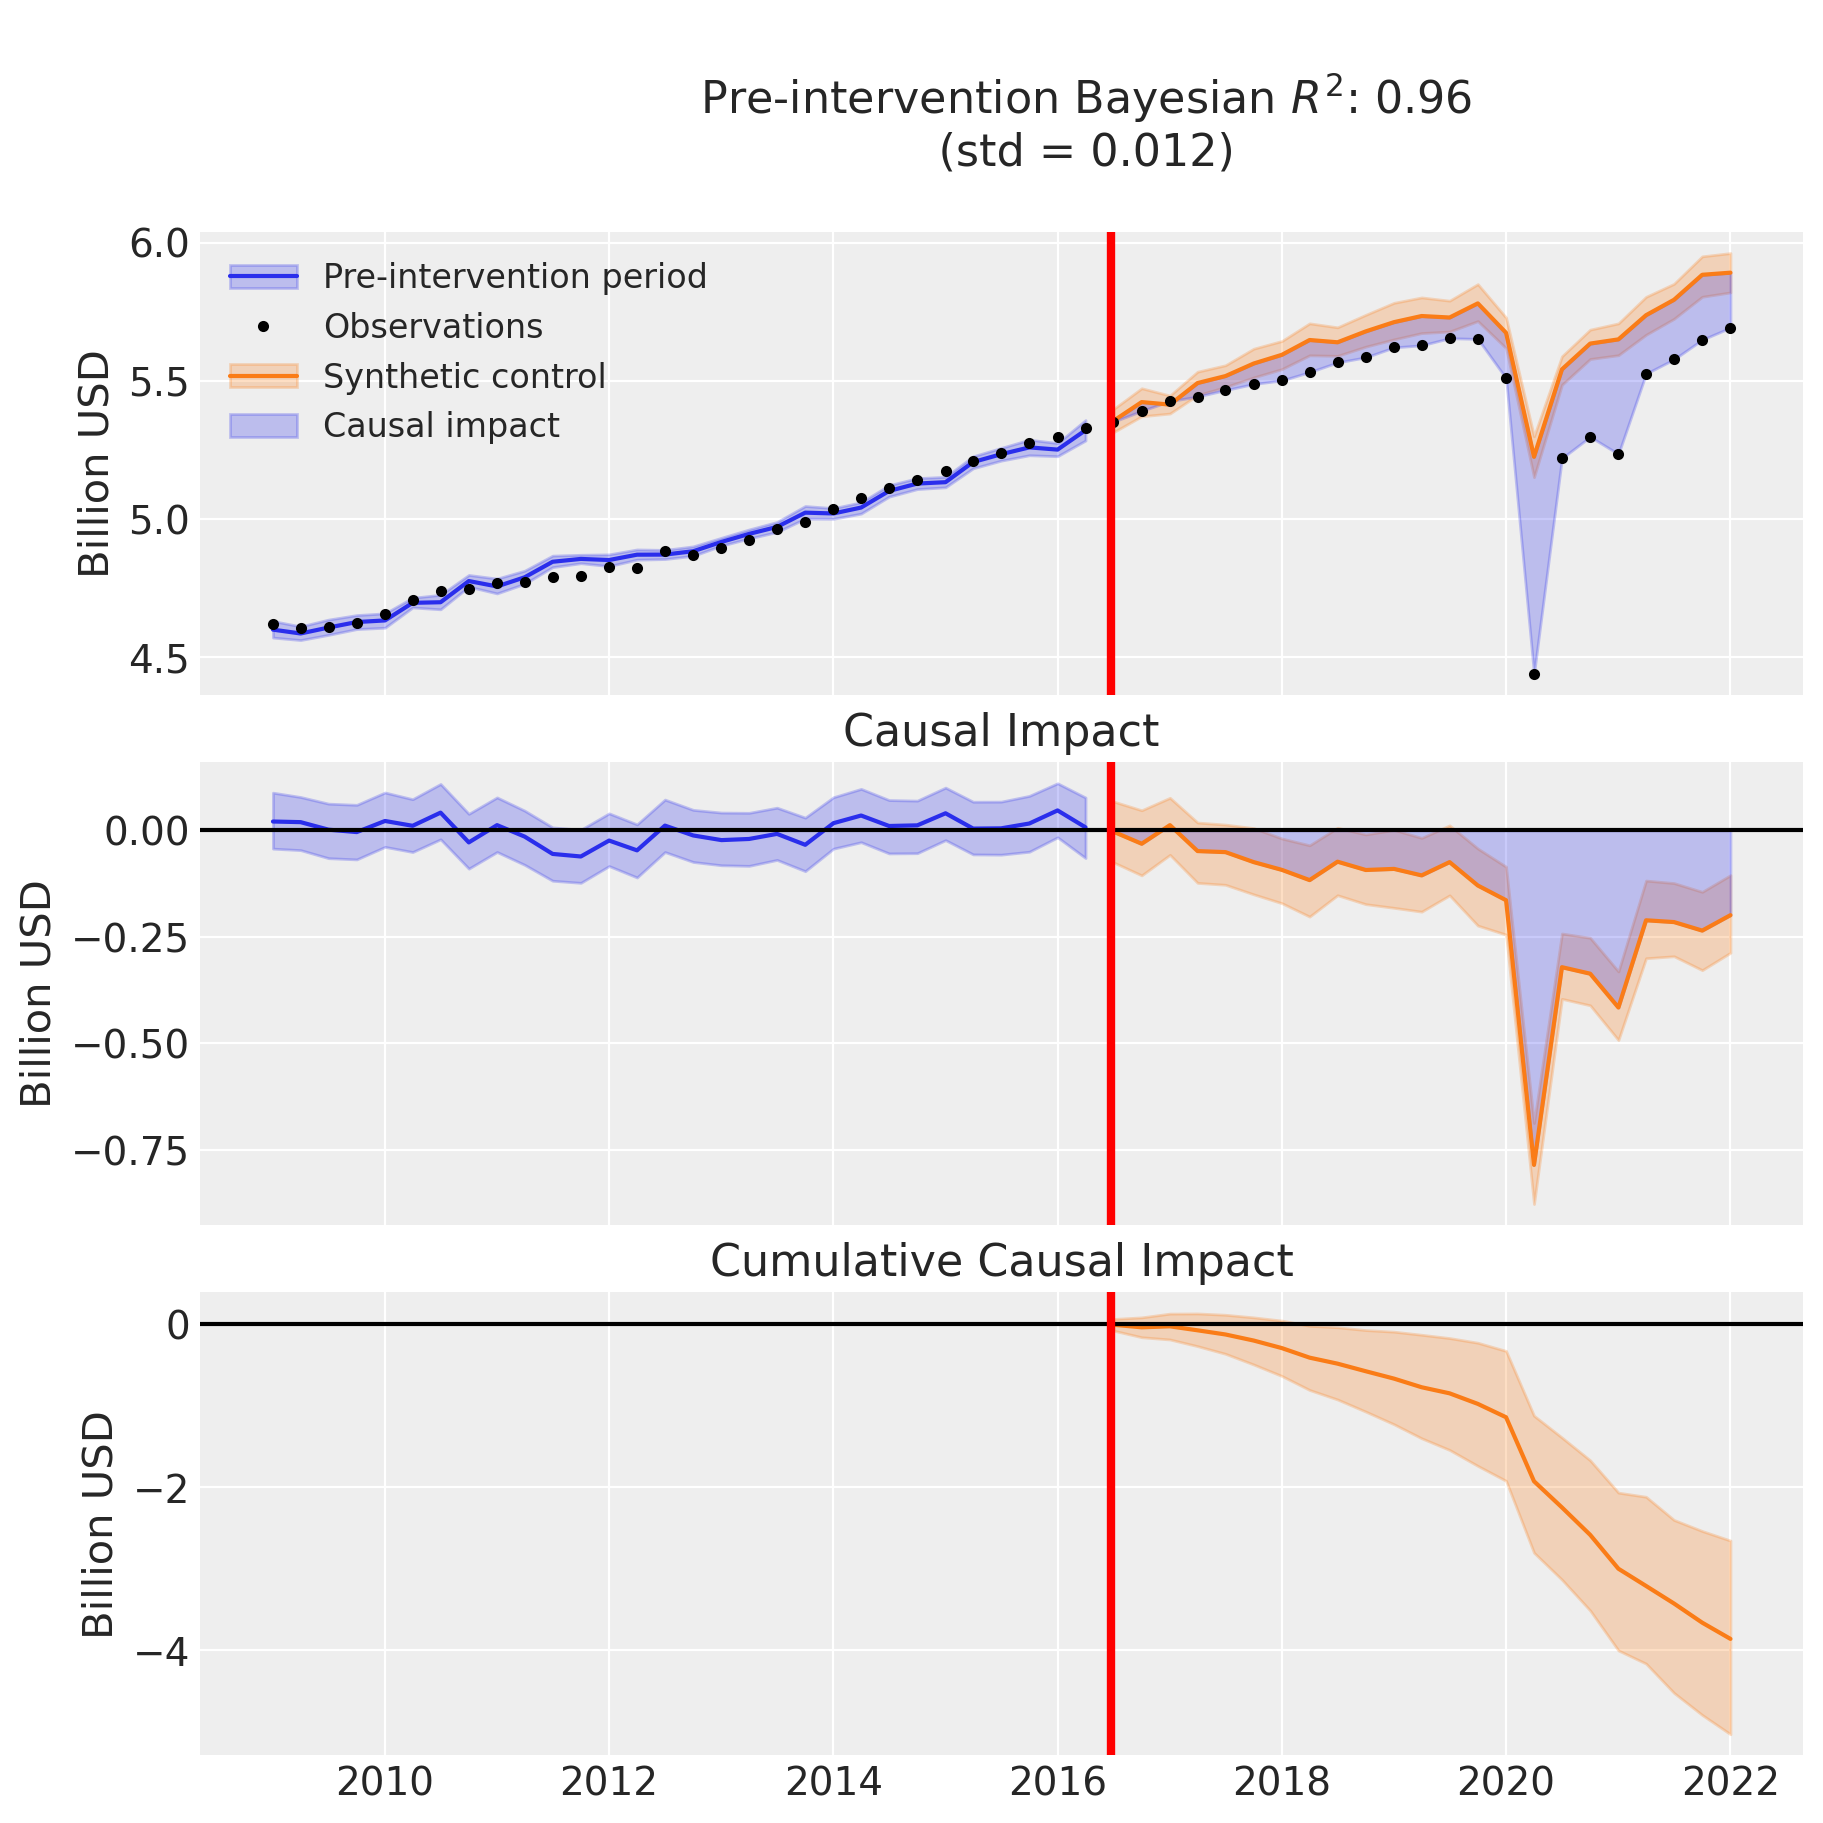

In [59]:
# Plot model results
fig, ax = result.plot(plot_predictors=False)
fig.set_size_inches(9,9)

for i in [0, 1, 2]:
    ax[i].set(ylabel="Billion USD")

We can see above that the Bayesian R2 value for the pre-treatment data is pretty high (0.96) considering this is real-world data. It shows that the linear weighted combination model (the core of synthetic control) is doing a reasonable job at constructing a synthetic UK up until the treatment period.

In [60]:
result.summary()

==================================Pre-Post Fit==================================
Formula: UK ~ 0 + Australia + Austria + Belgium + Canada + Denmark + Finland + France + Germany + Iceland + Japan + Luxemburg + Netherlands + New_Zealand + Norway + Sweden + Switzerland
Model coefficients:
Australia                     0.12, 94% HDI [0.007, 0.27]
Austria                       0.043, 94% HDI [0.0014, 0.14]
Belgium                       0.051, 94% HDI [0.0017, 0.16]
Canada                        0.038, 94% HDI [0.0038, 0.085]
Denmark                       0.077, 94% HDI [0.0039, 0.2]
Finland                       0.039, 94% HDI [0.0012, 0.13]
France                        0.027, 94% HDI [0.0014, 0.09]
Germany                       0.027, 94% HDI [0.0012, 0.086]
Iceland                       0.16, 94% HDI [0.081, 0.23]
Japan                         0.032, 94% HDI [0.0013, 0.1]
Luxemburg                     0.05, 94% HDI [0.0012, 0.16]
Netherlands                   0.042, 94% HDI [0.00077, 0.1

[Text(0.5, 1.0, 'Estimated country weight coefficients')]

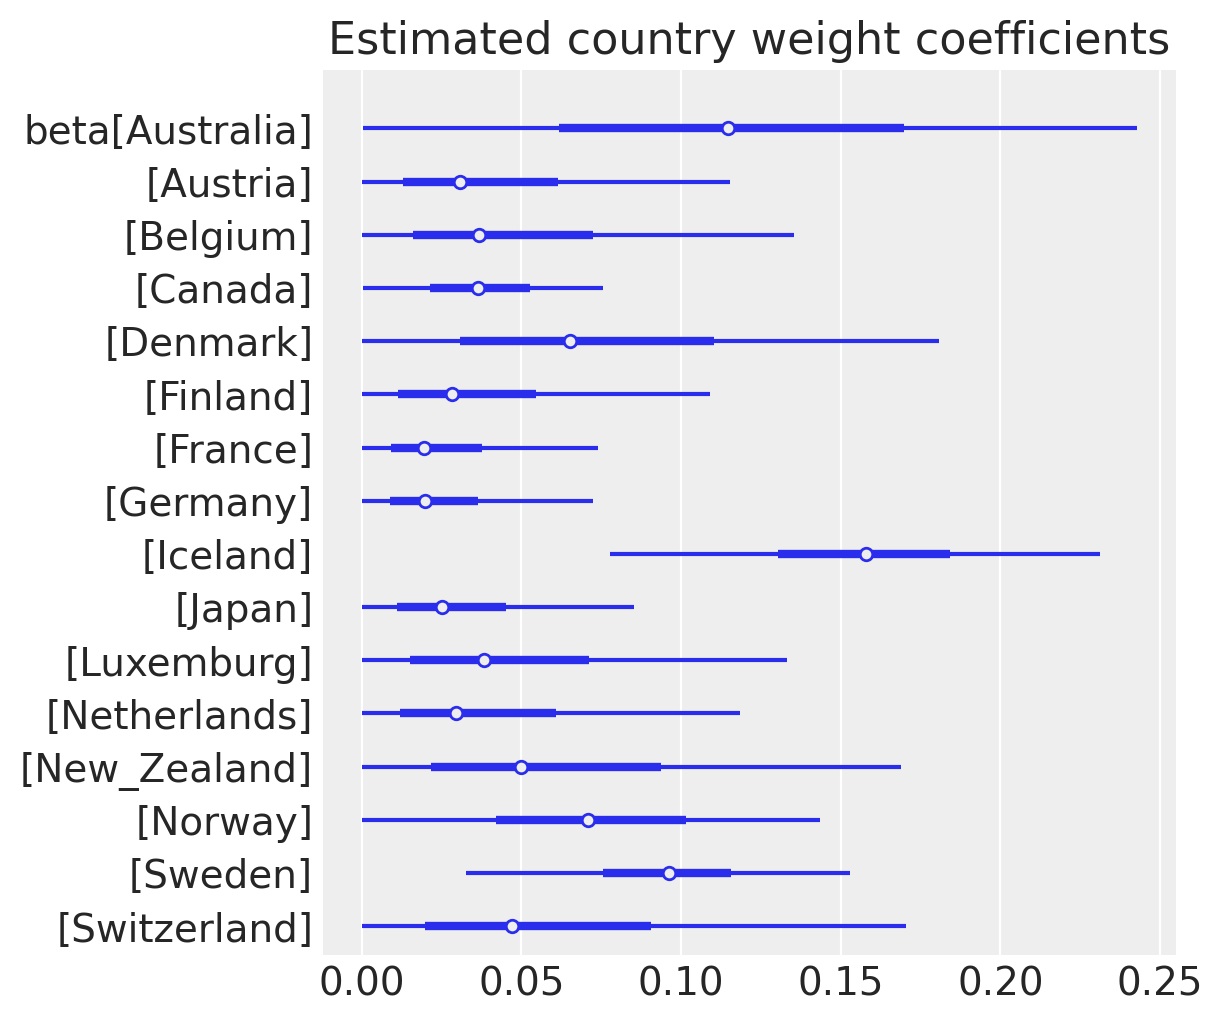

In [62]:
# Plot distribution of country weight coefficients
ax = az.plot_forest(result.idata, var_names="beta", figsize=(6, 5), combined=True)
ax[0].set(title="Estimated country weight coefficients")

We can also look at the estimated cumulative causal impact of Brexit (up to Jan 2022):

[Text(0.5, 1.0, "Estimated cumulative causal impact of Brexit on UK's GDP (till Jan 2022)"),
 Text(0.5, 0, 'Billion USD')]

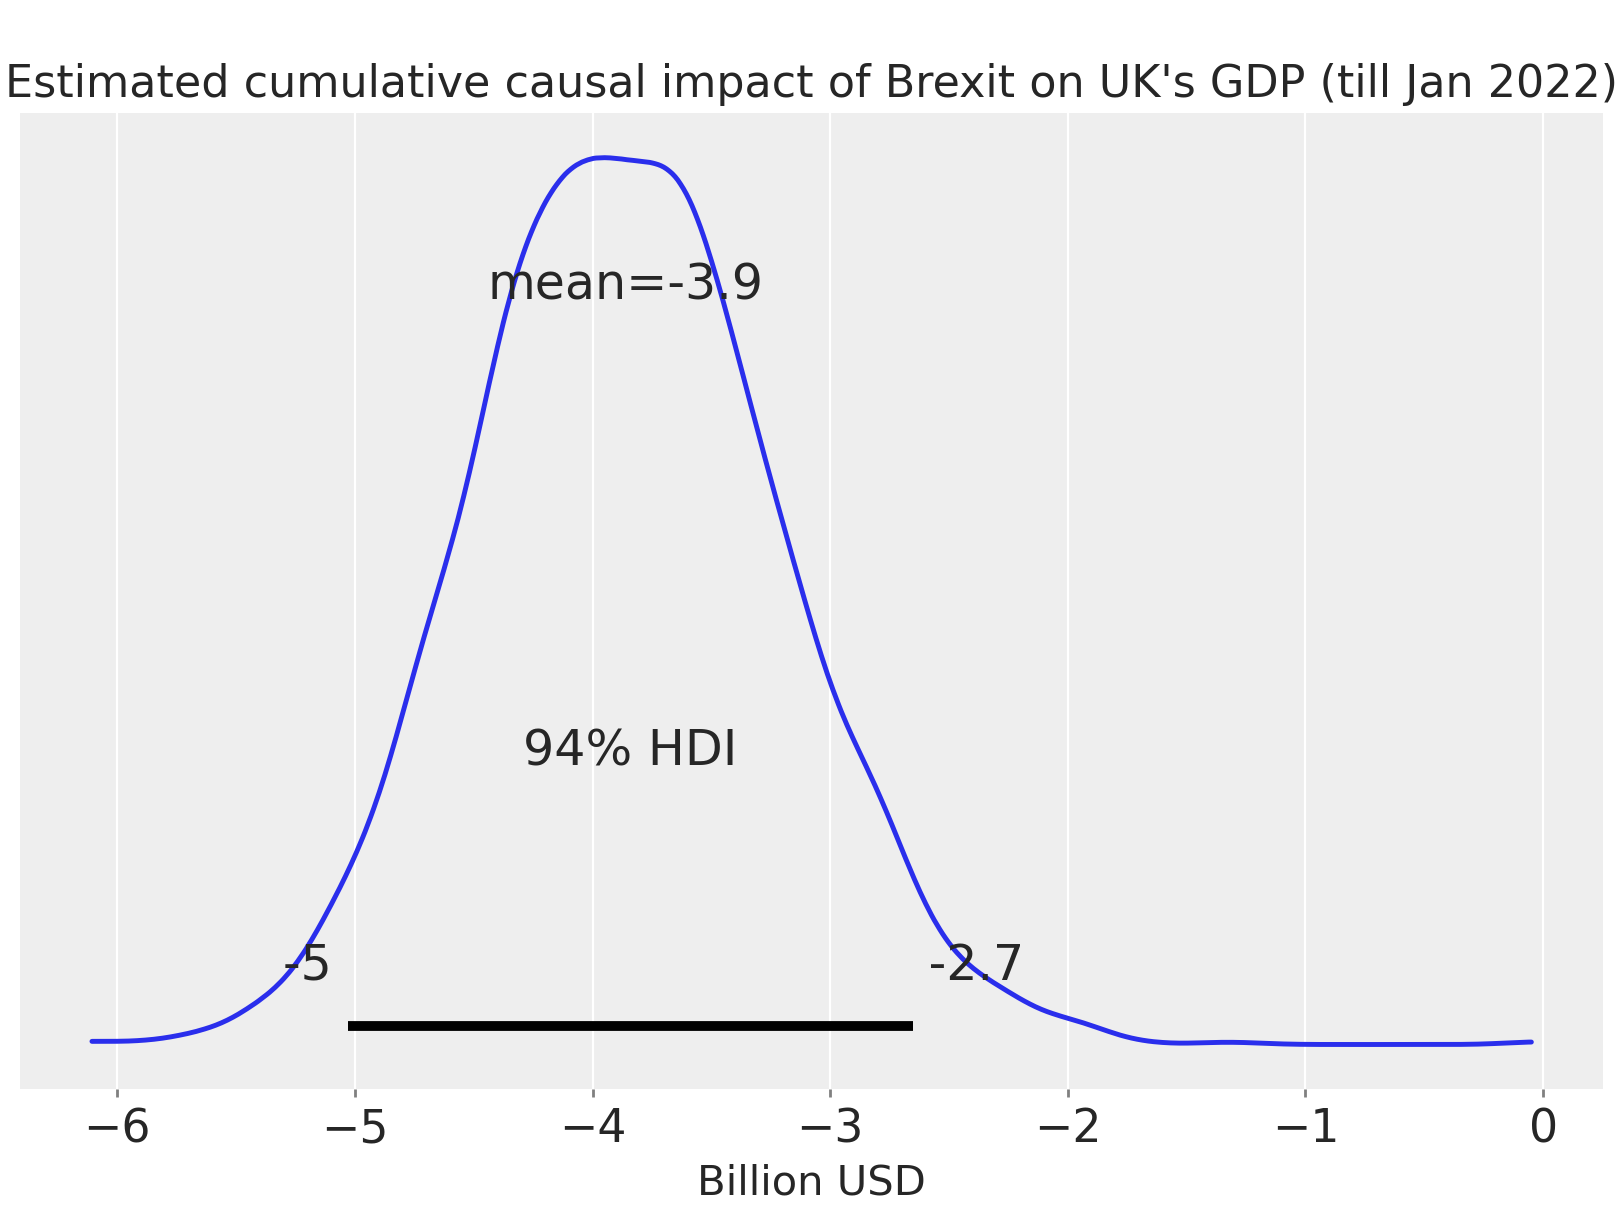

In [64]:
# get index of the final time point
index = result.post_impact_cumulative.obs_ind.max()
# grab the posterior distribution of the cumulative impact at this final time point
last_cumulative_estimate = result.post_impact_cumulative.sel({"obs_ind": index})
# get summary stats
ax = az.plot_posterior(last_cumulative_estimate, figsize=(8, 6))
ax.set(
    title="Estimated cumulative causal impact of Brexit on UK's GDP (till Jan 2022)",
    xlabel="Billion USD",
)

## Causal impact analsyis (Frequentist approach)

### Weighted proportion model

CausalPy offers several options to build synthetic controls using a frequentist approach.

First, we'll fit a Weighted Proportion model (basically a linear regression model which constraints weights to sum to 1 and be positive).

In [92]:
formula_filtered

'UK ~ 0 + Australia + Austria + Belgium + Canada + Denmark + Finland + France + Germany + Iceland + Japan + Luxemburg + Netherlands + New_Zealand + Norway + Sweden + Switzerland'

In [87]:
# Fitting the model
result_wp = cp.skl_experiments.SyntheticControl(
    df_filtered,
    treatment_time,
    formula=formula_filtered,
    model=cp.skl_models.WeightedProportion(),
)

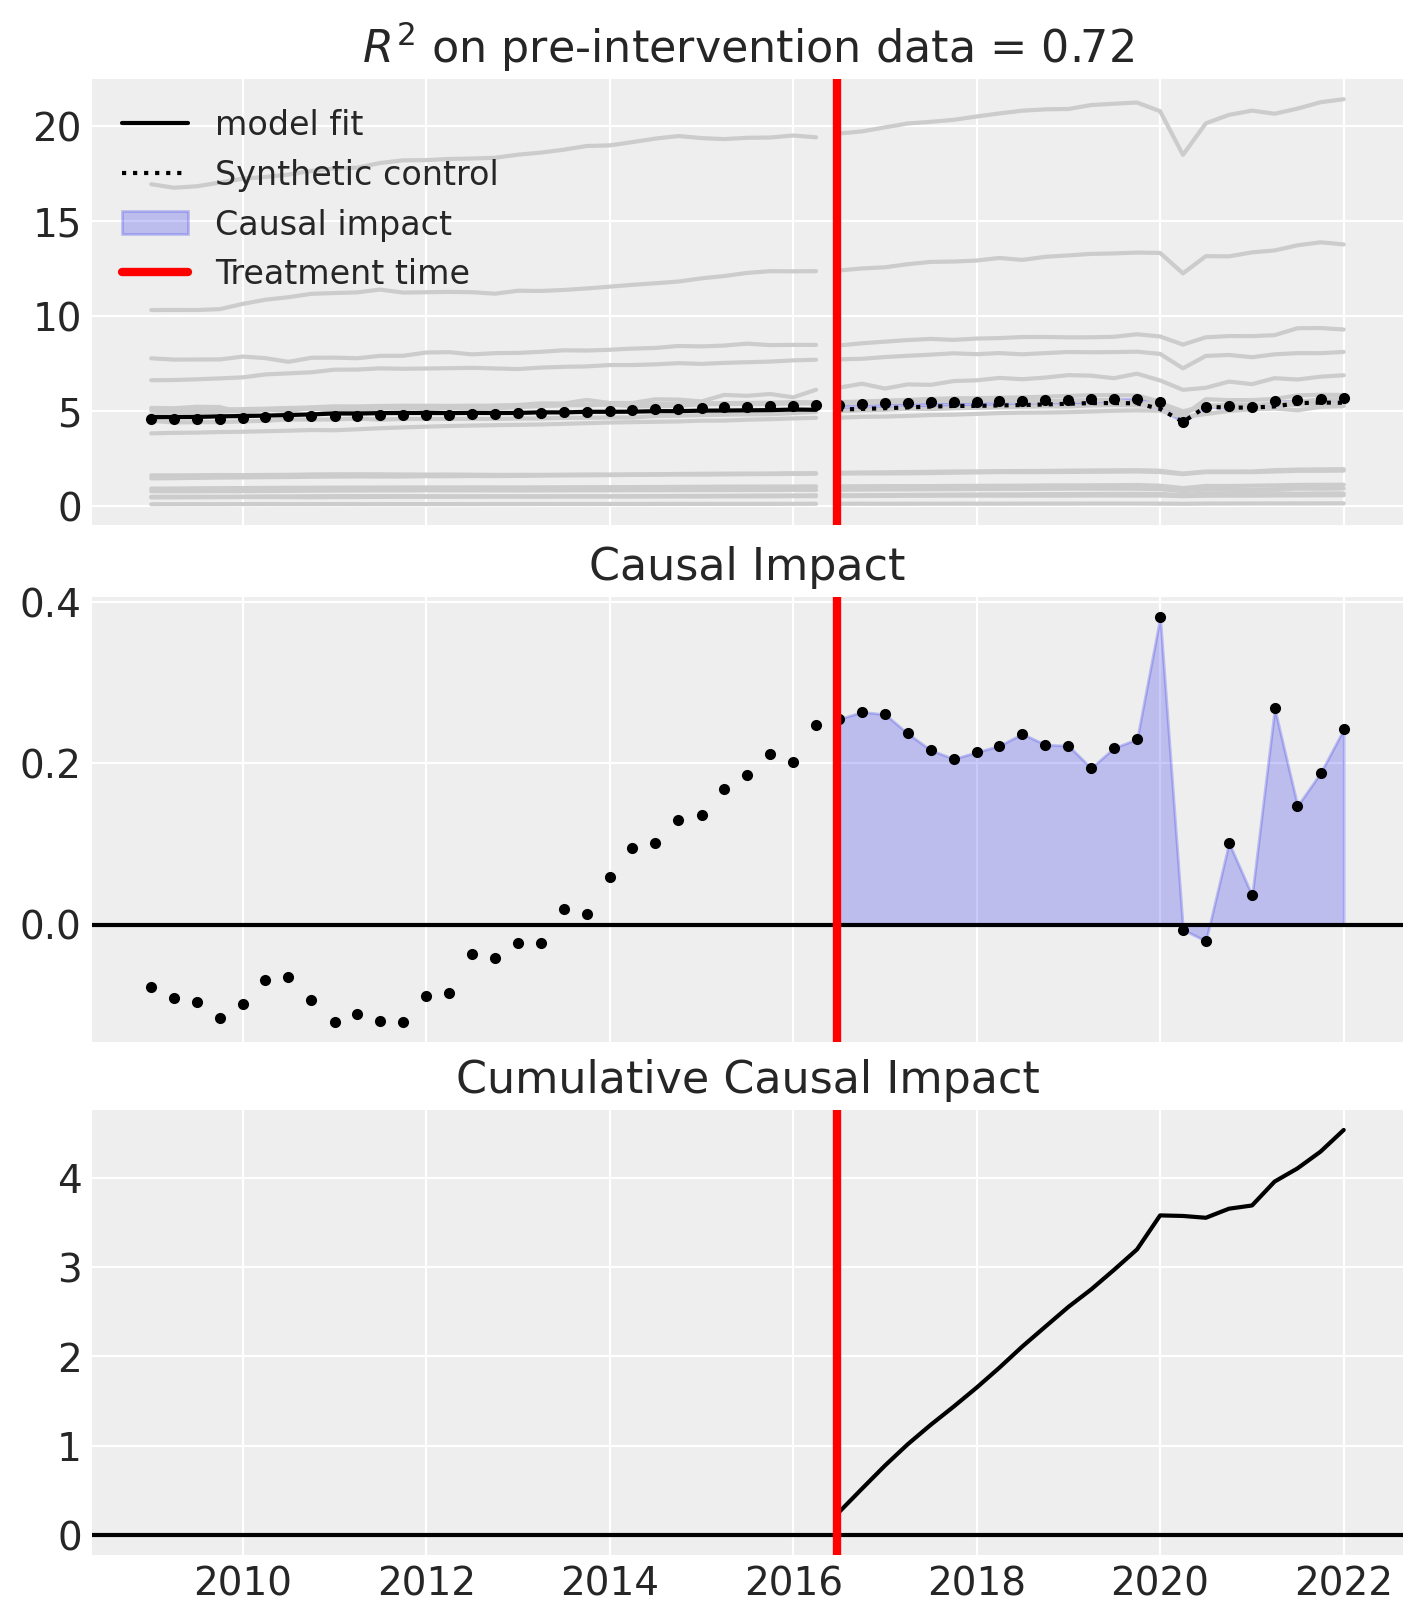

In [88]:
fig, ax = result_wp.plot(plot_predictors=True)

We can see that, for this dataset, these estimates are quite bad. See also the learned coefficients below:

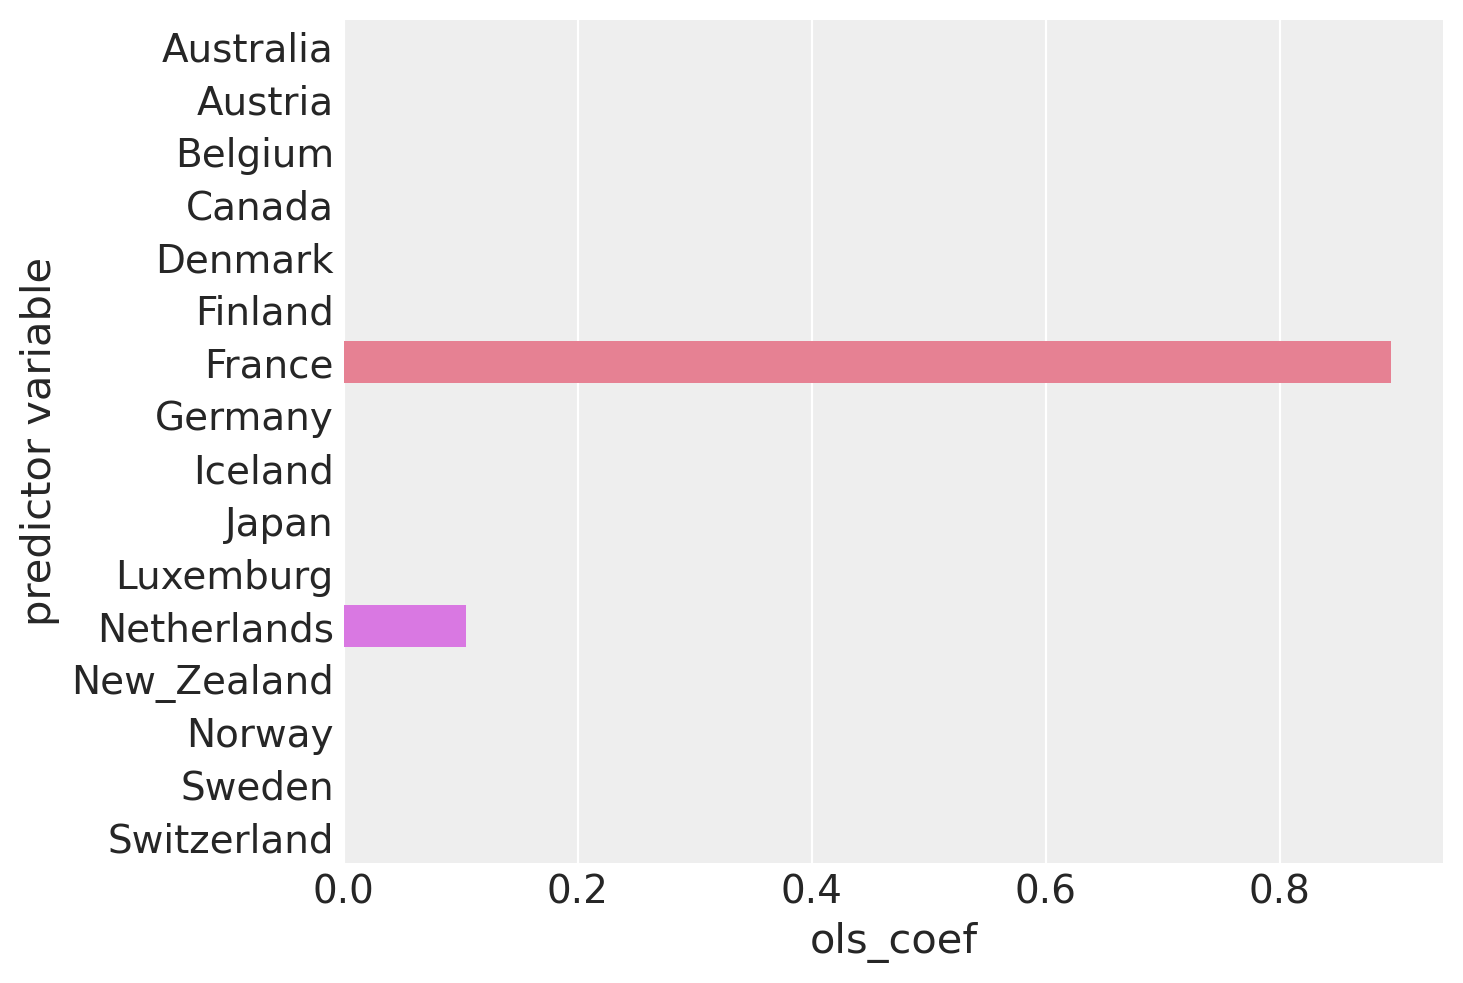

In [91]:
result_wp.plot_coeffs()

### Linear regression model

Next, we try to use a Linear Regression model, lifting the "sum to 1" assumption but still constraining weights to be positive.

In [93]:
lr_result = cp.skl_experiments.SyntheticControl(
    df_filtered,
    treatment_time,
    formula=formula_filtered,
    model=LinearRegression(positive=True),
)

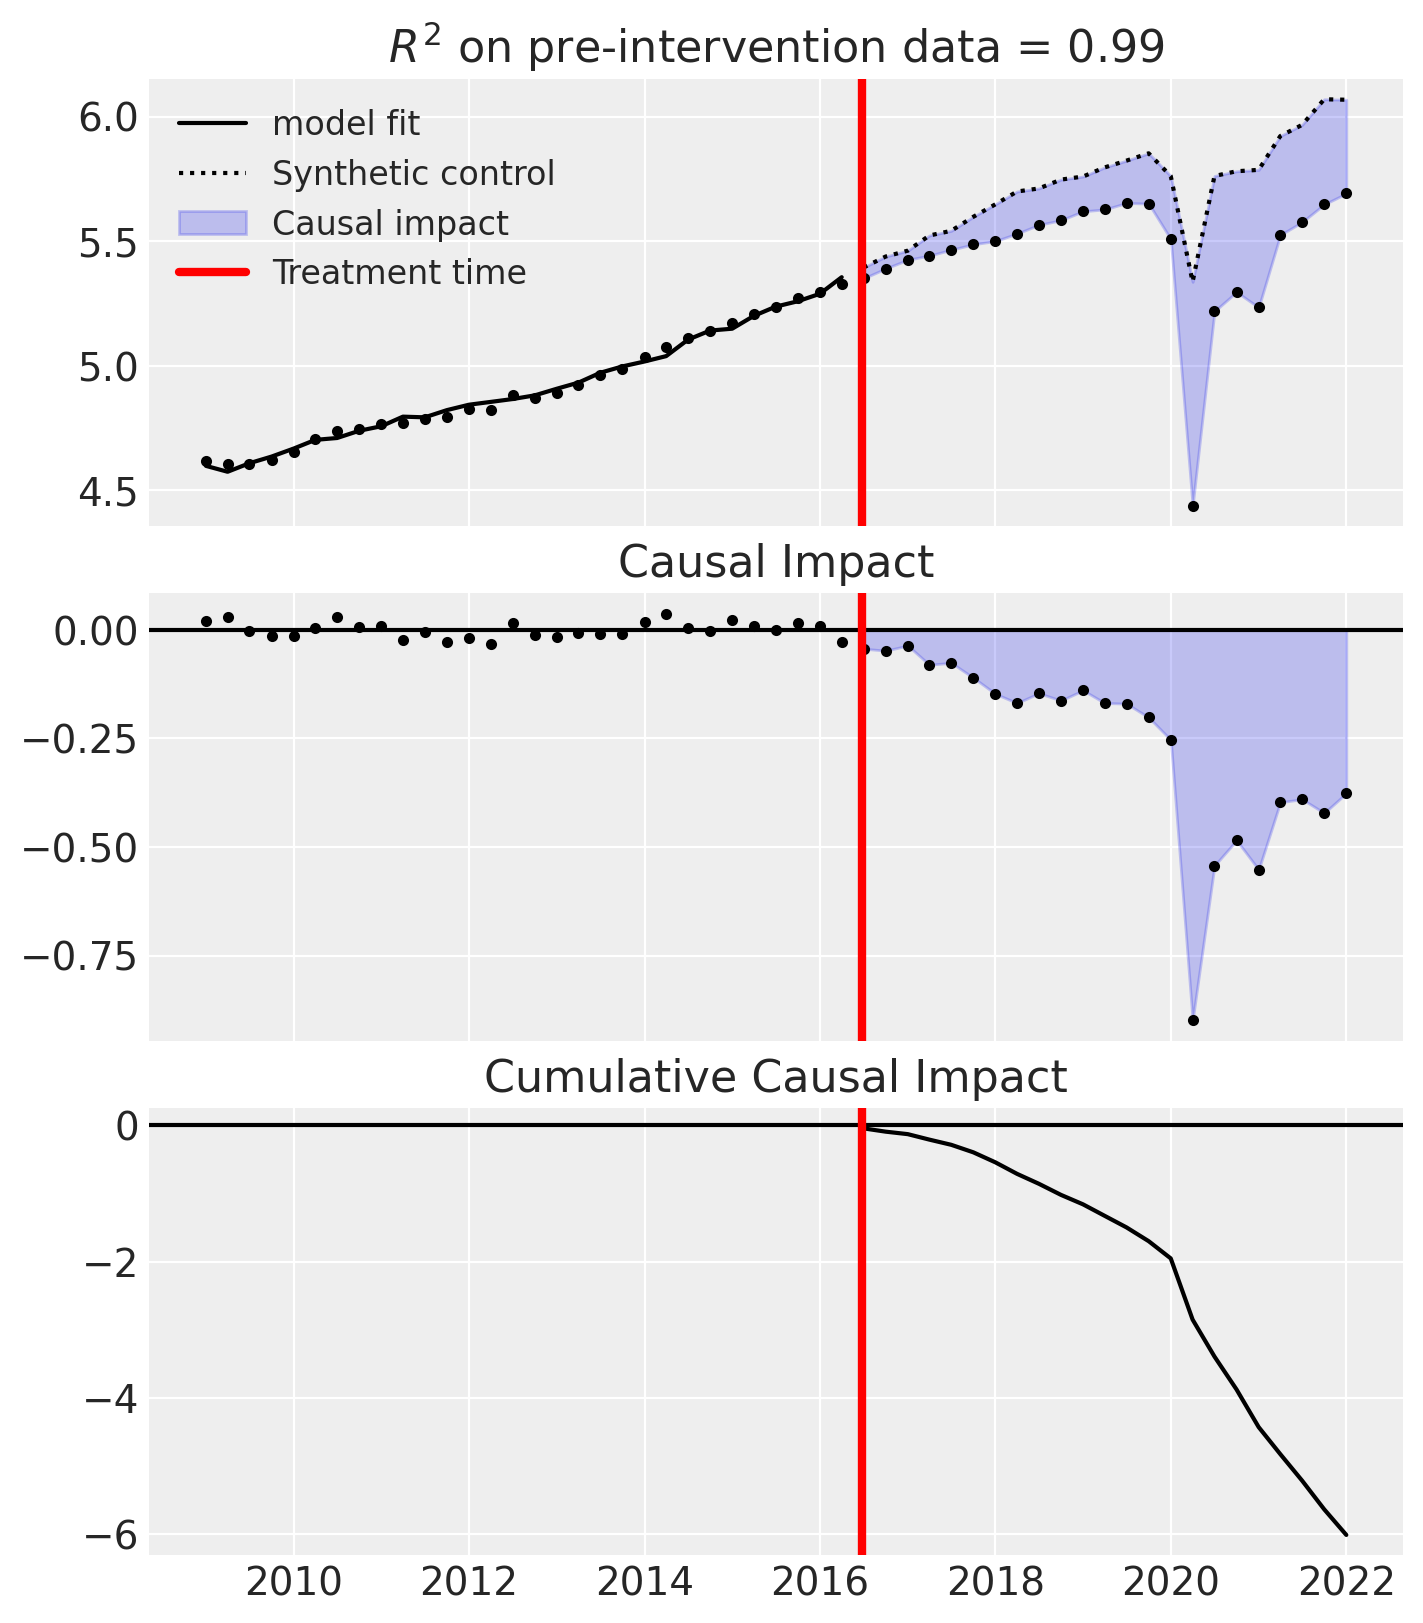

In [94]:
fig, ax = lr_result.plot()

We got a much better fit now, and comparable results to the bayesian approach. Let's explore the coefficients now:

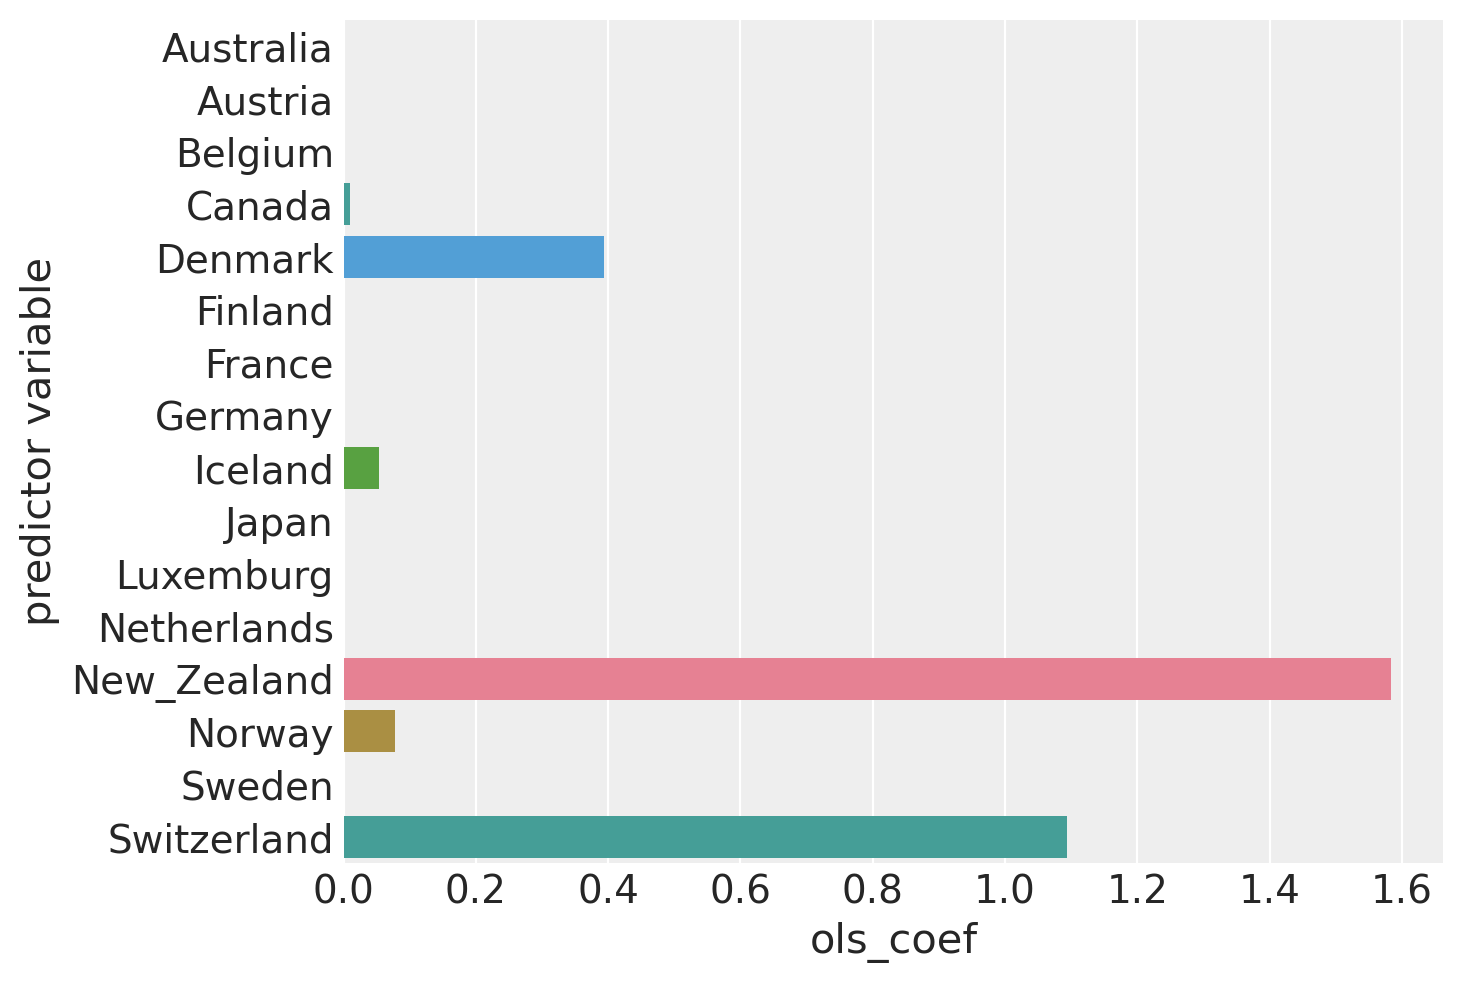

In [95]:
lr_result.plot_coeffs()

### Ridge model

We can also use a regularised linear model such as Ridge regression to estimate the synthetic control. In this case it will be important to properly set the regularisation strenght with the alpha term. As an example, I set alpha to 10.

In [105]:
ridge_result = cp.skl_experiments.SyntheticControl(
    df_filtered,
    treatment_time,
    formula=formula_filtered,
    model=Ridge(positive=True, alpha=10),
)

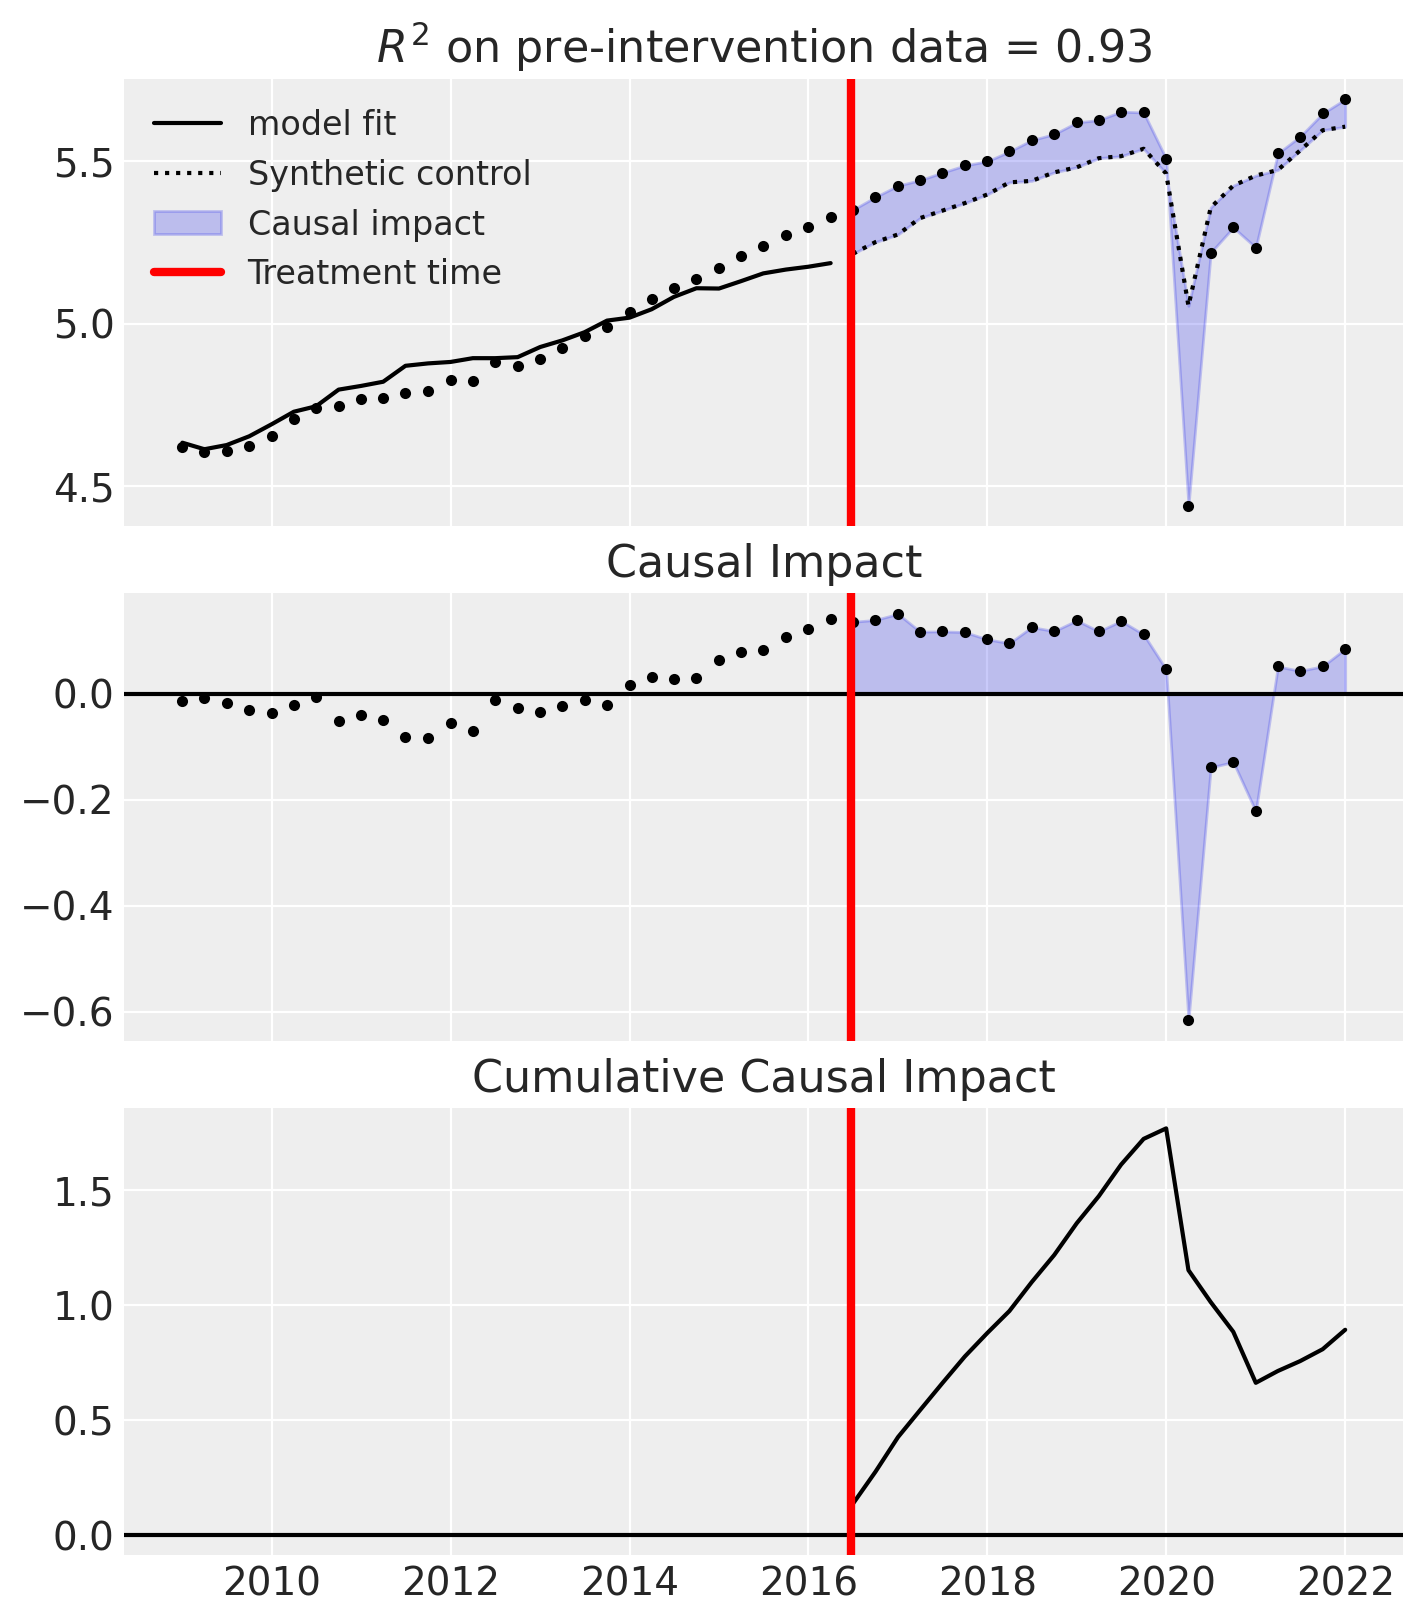

In [106]:
fig, ax = ridge_result.plot()

We can see that the estimates are not great after applying regularisation to our model. The standard linear model had the best performance on this dataset.

Below we can see the effects of regularisation: since large values are penalised, the synthetic control is built using a combination of many more countries with smaller weights.

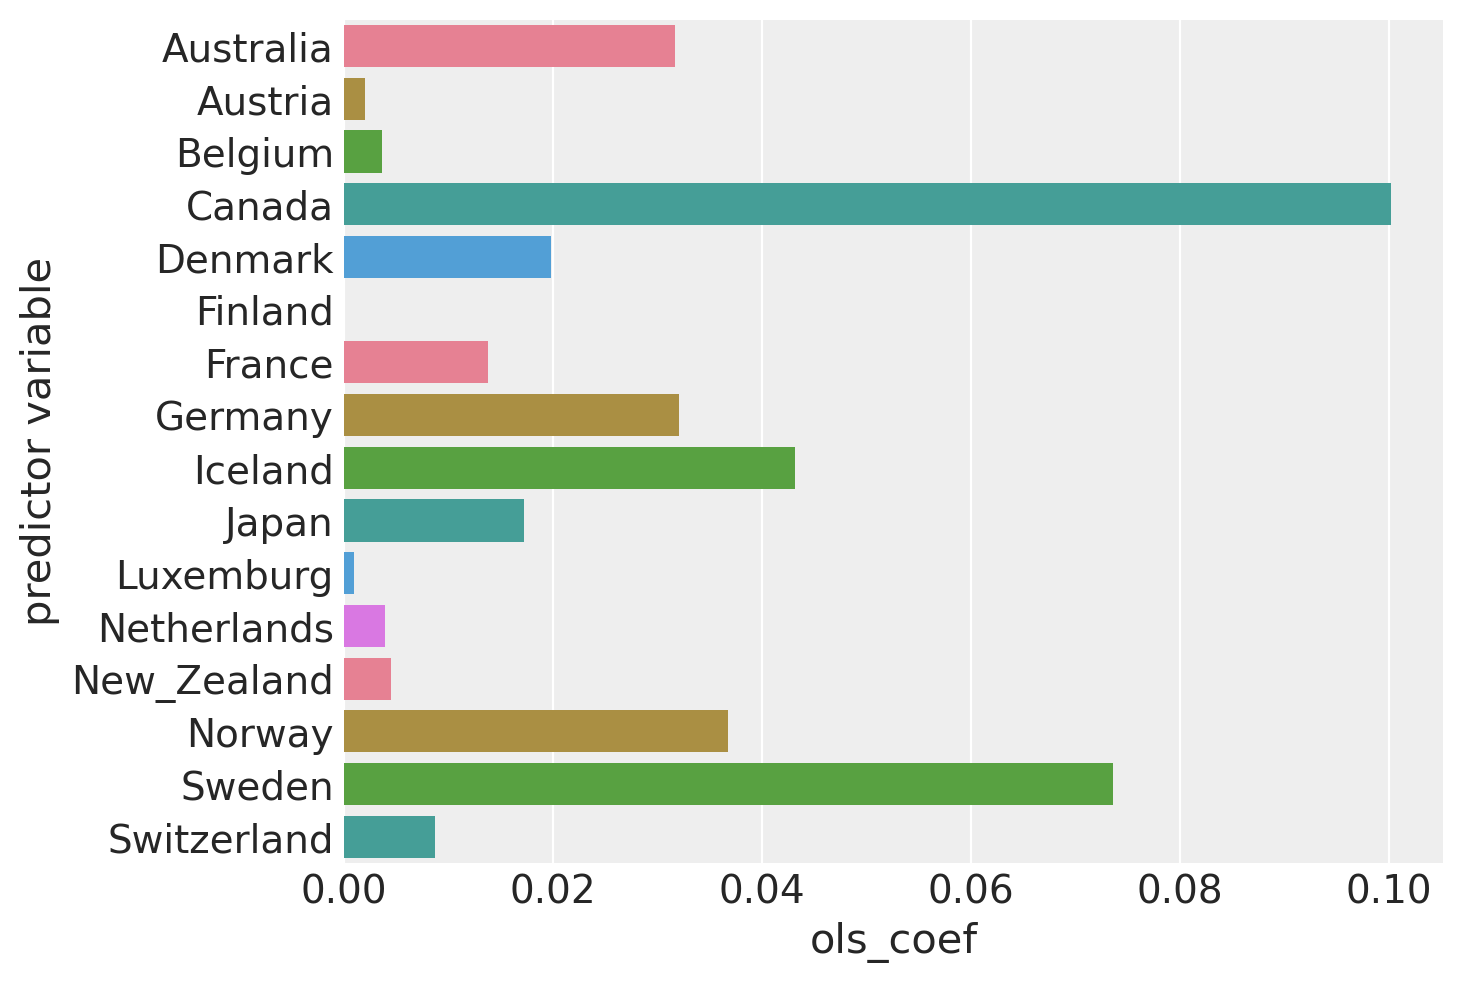

In [107]:
ridge_result.plot_coeffs()